 78%|███████▊  | 5559/7129 [00:09<00:02, 578.30it/s]


Epoch 1/50
157/157 [==============================] - 11s 73ms/step - loss: 0.0244 - val_loss: 0.0157
Epoch 2/50
157/157 [==============================] - 11s 69ms/step - loss: 0.0139 - val_loss: 0.0135
Epoch 3/50
157/157 [==============================] - 11s 68ms/step - loss: 0.0128 - val_loss: 0.0131
Epoch 4/50
157/157 [==============================] - 11s 68ms/step - loss: 0.0121 - val_loss: 0.0127
Epoch 5/50
157/157 [==============================] - 11s 68ms/step - loss: 0.0116 - val_loss: 0.0122
Epoch 6/50
157/157 [==============================] - 11s 68ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 7/50
157/157 [==============================] - 11s 68ms/step - loss: 0.0107 - val_loss: 0.0112
Epoch 8/50
157/157 [==============================] - 11s 68ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 9/50
157/157 [==============================] - 11s 68ms/step - loss: 0.0100 - val_loss: 0.0109
Epoch 10/50
157/157 [==============================] - 11s 68ms/step - loss: 0.009

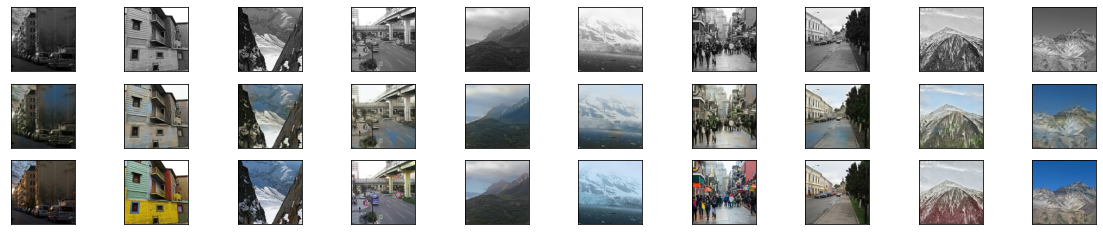

In [15]:
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D
from keras.models import Model
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# Define the size of the image
SIZE = 160

# Load color images
color_img = []
path_color = '../input/landscape-image-colorization/landscape Images/color'
files_color = os.listdir(path_color)
files_color = sorted(files_color)
for i in tqdm(files_color):    
    if i == '6000.jpg':
        break
    img = cv2.imread(os.path.join(path_color, i), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    color_img.append(img_to_array(img))

# Load grayscale images
gray_img = []
path_gray = '../input/landscape-image-colorization/landscape Images/gray'
files_gray = os.listdir(path_gray)
files_gray = sorted(files_gray)
for i in tqdm(files_gray):
    if i == '6000.jpg':
        break
    img = cv2.imread(os.path.join(path_gray, i), 0)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    gray_img.append(img_to_array(img))

# Convert lists to numpy arrays
color_img = np.array(color_img)
gray_img = np.array(gray_img)

# Define the autoencoder model
input_img = Input(shape=(SIZE, SIZE, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create the model
autoencoder = Model(input_img, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
autoencoder.fit(gray_img, color_img, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

# Save the model
autoencoder.save('colorization_autoencoder.h5')

# Test the model on some images
decoded_imgs = autoencoder.predict(gray_img)

# Display the results
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(gray_img[i].reshape(SIZE, SIZE), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display original color image
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(color_img[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
